# 📦 E-commerce Delivery Time Prediction Product Delivery Time for an Electronics Store

## 1. Project Overview
In this notebook, we aim to predict whether an e-commerce order will be delivered on time using machine learning. We explore the dataset, build classification models, tune them, and save the best one for production.

## 2. Data Loading


In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [2]:
!pip install imblearn

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

import pickle

In [12]:
e_c = pd.read_csv('e_commerce.csv').drop('ID', axis=1)
e_c.shape

(10999, 11)

## 3. Exploratory Data Analysis (EDA)
Basic inspection and insights.

In [13]:
e_c.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [14]:
e_c.isnull().sum()

,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0
Weight_in_gms,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945.4+ KB


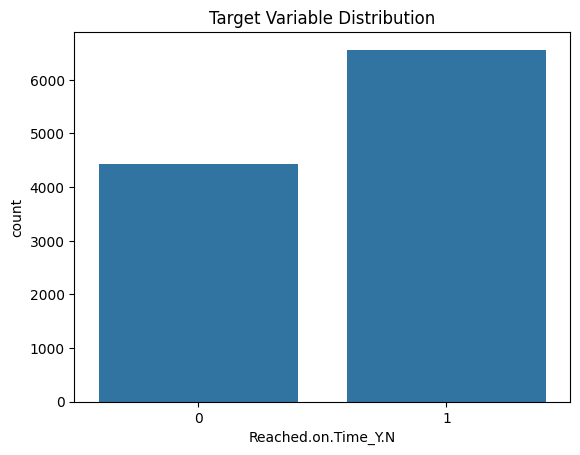

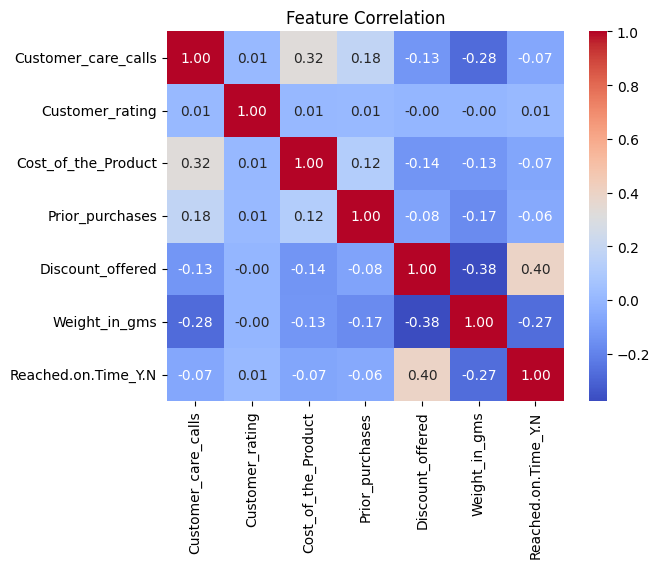

In [15]:
e_c.info()
e_c.describe()
e_c['Reached.on.Time_Y.N'].value_counts(normalize=True)

sns.countplot(x='Reached.on.Time_Y.N', data=e_c)
plt.title("Target Variable Distribution")
plt.show()

numeric_features = e_c.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(e_c[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

### 🔥 Feature Correlation Heatmap

The heatmap above shows Pearson correlations between numerical features and the target variable `Reached.on.Time_Y.N`.

#### Key Insights:

- **Target Variable (`Reached.on.Time_Y.N`)**:
  - Positively correlated with `Discount_offered` (**+0.40**): Higher discounts are linked to more late deliveries, possibly due to lower shipping priority or promotional overload.
  - Negatively correlated with `Weight_in_gms` (**-0.27**): Heavier packages are slightly more prone to delays.
  - Other features show weak correlations with the target (absolute values < 0.10), suggesting limited linear influence.

- **Inter-feature Relationships**:
  - `Customer care calls` and `Cost_of_the_Product` show a mild positive correlation (**+0.32**), indicating more expensive products might result in more inquiries.
  - `Discount_offered` and `Weight_in_gms` are moderately negatively correlated (**-0.38**), hinting that lighter items might receive larger discounts.

#### Implications:
- **Key predictive features** based on correlation:
  - `Discount_offered`
  - `Weight_in_gms`
- **Non-informative features** (in terms of correlation):
  - `Customer_rating`, `Prior_purchases`, and `Customer care calls` may have limited linear impact, but could still be useful with non-linear models.



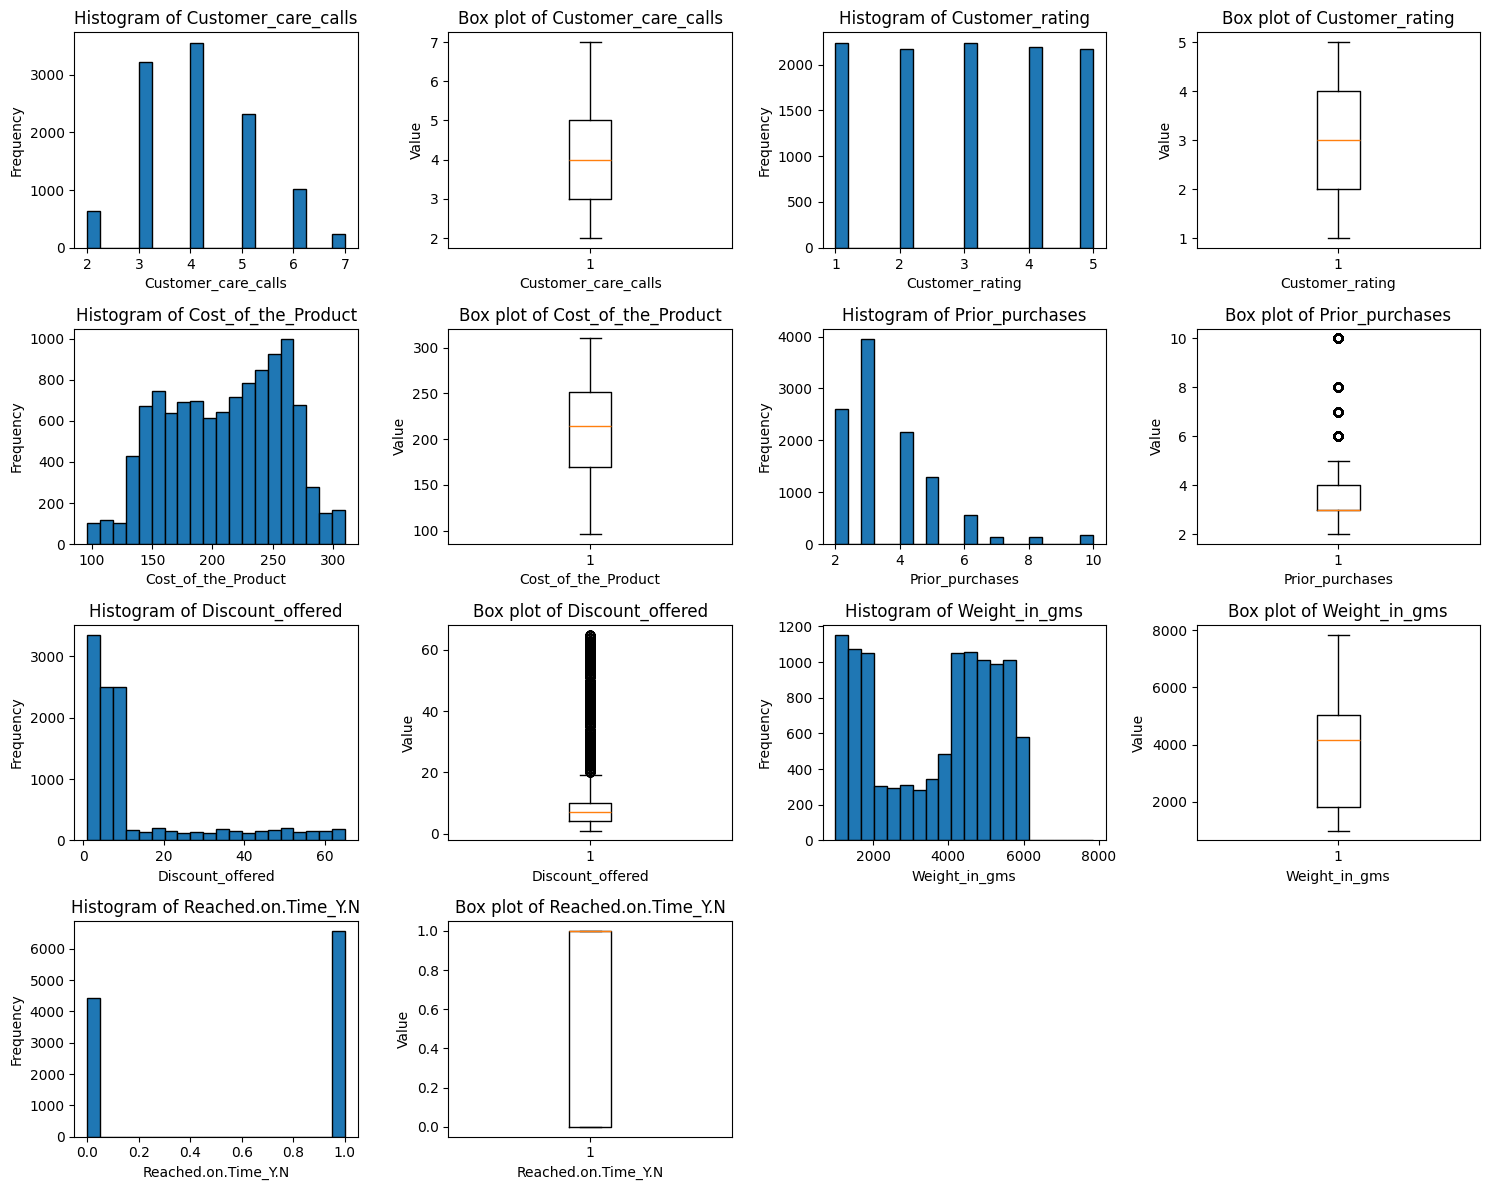

In [17]:
e_c_numeric = e_c.select_dtypes(include=np.number)
numeric_columns = e_c_numeric.columns

n_cols = 4
n_rows = int(np.ceil(len(numeric_columns) * 2 / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    # Histogram
    axes[i*2].hist(e_c_numeric[column], bins=20, edgecolor='black')
    axes[i*2].set_title(f'Histogram of {column}')
    axes[i*2].set_xlabel(column)
    axes[i*2].set_ylabel('Frequency')

    # Box plot
    axes[i*2+1].boxplot(e_c_numeric[column])
    axes[i*2+1].set_title(f'Box plot of {column}')
    axes[i*2+1].set_xlabel(column)
    axes[i*2+1].set_ylabel('Value')

# Remove any unused subplots
for j in range(len(numeric_columns) * 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 📊 Distribution & Outlier Analysis

Above are histograms and box plots for the key numeric variables to understand their distribution, central tendency, and potential outliers.

#### Key Observations:

- **Customer care calls**:
  - Most customers made between 3 and 5 calls.
  - Minimal outliers; fairly discrete distribution.

- **Customer rating**:
  - Ratings are nearly uniformly distributed across all 5 levels.
  - No significant skew or outliers observed.

- **Cost of the Product**:
  - Appears normally distributed between \$100 and \$300.
  - A few mild outliers on both ends, but nothing extreme.

- **Prior purchases**:
  - Most customers have 2–4 prior purchases.
  - A few outliers with 7+ purchases visible in the box plot.

- **Discount offered**:
  - Right-skewed (most values are low discounts).
  - Many outliers in the higher range, indicating large discounts for some customers.

- **Weight in grams**:
  - Bimodal distribution — two peaks around 2000g and 5000g.
  - Wide range with significant variance, but no extreme outliers.

- **Reached on Time (target)**:
  - Imbalanced target — more orders are delivered on time (0) than late (1).
  - This will impact model performance and should be addressed (e.g., SMOTE or class weights).



## 4. Data Preprocessing
Encode, scale, and split data.

In [19]:
categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

e_c_encoded = pd.get_dummies(e_c, columns=categorical_cols, drop_first=True)

boolean_cols = e_c_encoded.select_dtypes(include='bool').columns
e_c_encoded[boolean_cols] = e_c_encoded[boolean_cols].astype(int)

X = e_c_encoded.drop(columns=['Reached.on.Time_Y.N'])
y = e_c_encoded['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

display(e_c_encoded.head())

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_low,Product_importance_medium,Gender_M
0,4,2,177,3,44,1233,1,0,0,1,0,0,0,1,0,0
1,4,5,216,2,59,3088,1,0,0,0,1,0,0,1,0,1
2,2,2,183,4,48,3374,1,0,0,0,0,0,0,1,0,1
3,3,3,176,4,10,1177,1,1,0,0,0,0,0,0,1,1
4,2,2,184,3,46,2484,1,0,1,0,0,0,0,0,1,0


### Addressing Class Imbalance with SMOTE

Our exploratory data analysis revealed that the target variable, `Reached.on.Time_Y.N`, is imbalanced, with more orders being delivered on time (class 0) than late (class 1). This imbalance can cause machine learning models to be biased towards the majority class and perform poorly on the minority class (late deliveries), which is often the class of most interest in a business context.

To address this, we use **SMOTE (Synthetic Minority Over-sampling Technique)**. SMOTE works by creating synthetic samples of the minority class. It does this by selecting examples from the minority class that are close to each other in the feature space and then generating new, similar examples between them. This oversamples the minority class, making its representation in the training data more equal to that of the majority class.

By training our models on this balanced dataset, we aim to improve their ability to correctly identify and predict instances of the minority class, leading to a more robust and fairer model.

In [20]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Shape of X_train before SMOTE:", X_train.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Distribution of y_train before SMOTE:\n", y_train.value_counts())
print("Distribution of y_train after SMOTE:\n", y_train_resampled.value_counts())

Shape of X_train before SMOTE: (8799, 15)
Shape of X_train after SMOTE: (10500, 15)
Distribution of y_train before SMOTE:
 Reached.on.Time_Y.N
1    5250
0    3549
Name: count, dtype: int64
Distribution of y_train after SMOTE:
 Reached.on.Time_Y.N
0    5250
1    5250
Name: count, dtype: int64


## 5. Model Building & Evaluation
Try different models and evaluate them.

Fitting 3 folds for each of 34 candidates, totalling 102 fits
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=42))])
Best parameters: {'model': RandomForestClassifier(random_state=42), 'model__max_depth': 5, 'model__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.56      0.98      0.71       887
           1       0.97      0.47      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.67      2200
weighted avg       0.81      0.68      0.67      2200



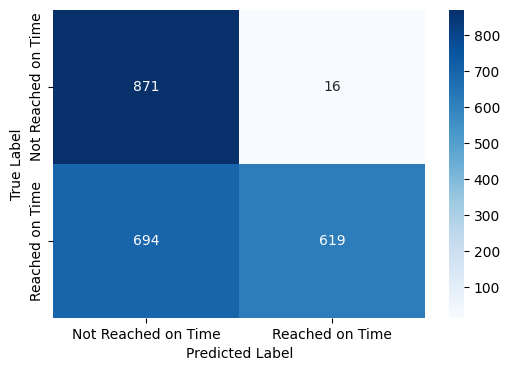

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Include the scaler in the pipeline
    ('model', LogisticRegression()) # Placeholder for the model
])

logistic_params = {
    'model': [LogisticRegression(solver='liblinear', random_state=42)],
    'model__C': [0.01, 0.1, 1, 10]
}

svc_params = {
    'model': [SVC(random_state=42)],
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf']
}

rf_params = {
    'model': [RandomForestClassifier(random_state=42)],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20]
}

knn_params = {
    'model': [KNeighborsClassifier()],
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ["uniform", "distance"]
}

catboost_params = {
    'model': [CatBoostClassifier(verbose=0, random_state=42)],
    'model__iterations': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

param_grid = [logistic_params, svc_params, rf_params, knn_params, catboost_params]


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy', # You can choose a different scoring metric if needed
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

best_model = grid_search.best_estimator_
print("Best model:", best_model)
print("Best parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
    cmap='Blues',
    xticklabels=['Not Reached on Time', 'Reached on Time'],
    yticklabels=['Not Reached on Time', 'Reached on Time'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Model Saving for Production
Save the best model using Pickle.

In [ ]:
# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# To load later:
# with open('best_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

## 7. Conclusion & Next Steps
Insights and deployment suggestions.

**Conclusion & Insights**:

- The dataset was successfully loaded and explored, revealing no missing values and a slight imbalance in the target variable (Reached.on.Time_Y.N).
- Categorical features were effectively handled using one-hot encoding.
- Several classification models were evaluated using GridSearchCV with a pipeline that included StandardScaler for robust tuning.
- The best model identified by GridSearchCV was a CatBoost Classifier with specific hyperparameters.
- The performance of the best model was evaluated on the test set using a classification report and confusion matrix, providing insights into its precision, recall, and overall accuracy.

**Next Steps**:



1.  Refine the Best Model: Although you have a best model, you could potentially try more extensive hyperparameter tuning for this specific CatBoost model to see if you can squeeze out a bit more performance.

2. Address Class Imbalance: The current results show a difference in performance between the two classes. Implementing techniques to handle class imbalance (as suggested in the plan) could potentially improve the model's ability to predict the minority class.

3. Model Interpretation: Explore techniques to understand which features are most important for the best model's predictions. This can provide valuable business insights.

4. Deployment: The best model has been saved using pickle. The next major step would be to deploy this saved model to make predictions on new, unseen data in a production environment. This would involve setting up an API or integrating it into a system that receives new order information.

5. Monitoring and Maintenance: Once deployed, it's crucial to monitor the model's performance over time and retrain it periodically with new data to ensure it remains accurate and relevant.

## 📈 Business Interpretation: From Model Insights to Logistics Strategy

### 🎯 Key Insight

The model identified **`Discount_offered`** and **`Weight_in_gms`** as the most influential predictors of late deliveries:

- High **discounts** increase the likelihood of a delayed shipment.
- **Heavier products** are also more prone to arriving late.

These insights suggest specific inefficiencies or bottlenecks in how promotional and bulky items are handled within the logistics chain.


### 🔍 Operational Linkage

These variables can be mapped to concrete operational processes:

- **Discounted Items**:
  - May be **batched separately**, shipped via **slower channels**, or receive **lower fulfillment priority**.
  - Often tied to **campaign-driven volume spikes**, straining logistics.

- **Heavy Products**:
  - Require **special handling**, custom packaging, or non-standard delivery routes.
  - Could involve **different carriers** or slower shipping methods.


### 💡 Business Actions

#### ✅ For High-Discount Orders:
- **Dedicated fulfillment stream**: Isolate promotional orders for more efficient processing.
- **Faster shipping options**: Automatically upgrade shipping methods when deep discounts are applied.
- **Set expectations**: Communicate longer delivery windows at checkout.

#### ✅ For Heavier Items:
- **Carrier partnerships**: Work with specialized freight providers.
- **Warehouse optimization**: Redesign layout or flows to prioritize heavy-item picking/packing.
- **Flexible delivery pricing**: Offer incentives for slower shipping to reduce last-mile risk.


### 💰 Quantifying the Impact

To build a business case for intervention:

- Estimate cost per **late delivery**: Returns, lost sales, support overhead, and customer churn.
- Calculate how much of that cost is attributable to **discounted** or **heavy** shipments.
- Even a **5–10% reduction in late deliveries** could yield significant savings and boost customer satisfaction.


### 🔄 Monitor, Iterate, Improve

- After implementing interventions, **track model predictions vs. actual delivery times**.
- Use new delivery data to **retrain the model** quarterly or seasonally.
- Look for **shifting predictors** as logistics operations evolve.


### 🧭 Communicate Clearly Across Teams

Present these findings to operations, logistics, sales, and marketing teams in **non-technical terms**:

- **“Discounted items are 40% more likely to arrive late — here's how we fix it.”**
- Focus on **actionable insights** that improve customer experience and operational efficiency.


### 🚀 Summary

By bridging data science insights with logistics strategy, the company can:
- Reduce late deliveries
- Lower operational costs
- Improve customer retention
- Build a smarter, more resilient supply chain
